# Баланс смещения и дисперсии для интерполяции полиномами разной сложности

**Компромисс отклонение-дисперсия** — это свойство набора моделей предсказания, когда модели с меньшим отклонением от имеющихся данных имеют более высокую дисперсию на новых данных (то есть подвержены переобучению), и наоборот.

**Проблема:** выбираемая модель должна, с одной стороны, *точно уловить все закономерности в обучающих данных*, а с другой стороны — *обобщить закономерности на неизвестных данных*.

- ***Смещение*** — это погрешность оценки, возникающая в результате ошибочного предположения в алгоритме обучения. В результате большого смещения алгоритм может пропустить связь между признаками и выводом (недообучение).

- ***Дисперсия*** — это ошибка чувствительности к малым отклонениям в тренировочном наборе. При высокой дисперсии алгоритм может как-то трактовать случайный шум в тренировочном наборе, а не желаемый результат (переобучение).

In [170]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import random
np.random.seed(54)

In [171]:
def dist_function(x):
    """Ф-я синуса"""
    f_x = np.sin(x)
    return f_x

def gen_data(x):
    """Генерация данных"""
    f_x = dist_function(x)
    b = 0.4
    y = f_x + np.random.uniform(-b, b, len(x))
    sigma = 1/12*(2*b)**2
    return y, f_x, sigma

def get_rand_data(len_ratio, x, y, f_x):
    """Получение рандомных данных"""
    m = len(x)
    m_new = int(np.round(len_ratio*m))
    ind = random.sample(range(m), m_new)
    ind = np.sort(ind)

    x1 = x[ind]
    y1 = y[ind]
    f_x1 = f_x[ind]

    return x1, y1, f_x1

In [172]:
x_orig = np.arange(0, 4 * np.pi, .2)
y_orig, f_x_orig, sigma = gen_data(x_orig)
p_order = [1, 3, 5, 7, 9, 11]  # степени рассматриваемых полиномов
num_data = 2000  # кол-во объектов в датасете

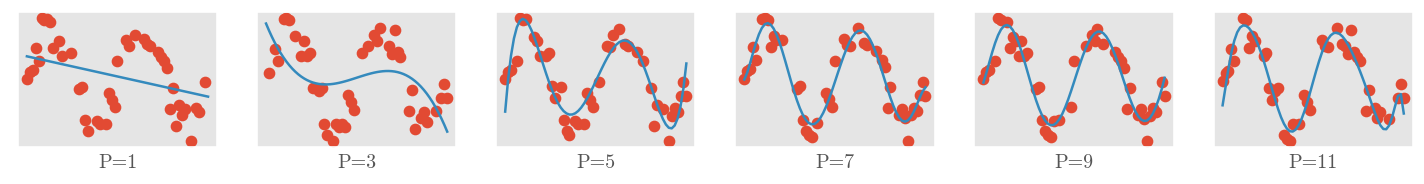

In [173]:
f, ax = plt.subplots(1, len(p_order), figsize=(15, 1.5), dpi=120, facecolor='w', edgecolor='k')
t = np.arange(0.1, 4*np.pi, .2)

P = []  # полиномы
bb = []  # смещения 
vv = []  # дисперсии

for i, p_val in enumerate(p_order):
    exp_f_x = np.zeros(len(t))
    exp_f_x_plot = np.zeros(len(x_orig))
    var = np.zeros(len(t))
    
    for j in range(num_data):
        x, y, f_x = get_rand_data(0.7, x_orig, y_orig, f_x_orig)
        p = np.poly1d(np.polyfit(x, y, p_val))
        P.append(p)
        exp_f_x = exp_f_x + p(t)
        exp_f_x_plot = exp_f_x_plot + p(x_orig)

    exp_f_x = exp_f_x / num_data
    exp_f_x_plot = exp_f_x_plot / num_data
    
    # рисуем интерполяцию
    ax[i].plot(x, y, 'o', x_orig, exp_f_x_plot)
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])
    ax[i].set_xlabel('P=' + str(p_order[i]))
    
    bias = np.linalg.norm(exp_f_x - dist_function(t))  # считаем смещение
    bb.append(bias)

    
    # считаем дисперсию
    for j in range(num_data):
        p_t = P.pop(0)
        var = var + np.square(p_t(t)-exp_f_x)
        
    var = var / num_data
    variance = np.linalg.norm(var)
    vv.append(variance)

In [174]:
print("СМЕЩЕНИЯ")
for i, v in enumerate(bb):
    print(' ', i+1, ':', v)

СМЕЩЕНИЯ
  1 : 5.169564598360542
  2 : 4.754365890019613
  3 : 1.7750486350126047
  4 : 0.5407067208087375
  5 : 0.5110982626443625
  6 : 1.4061484502139507


In [175]:
print("ДИСПЕРСИИ")
for i, v in enumerate(vv):
    print(' ', i+1, ':', v)

ДИСПЕРСИИ
  1 : 0.046363545400014215
  2 : 0.18691601617700185
  3 : 0.1964286882589875
  4 : 0.0726978596012303
  5 : 1.27395391143451
  6 : 16.10877129595576


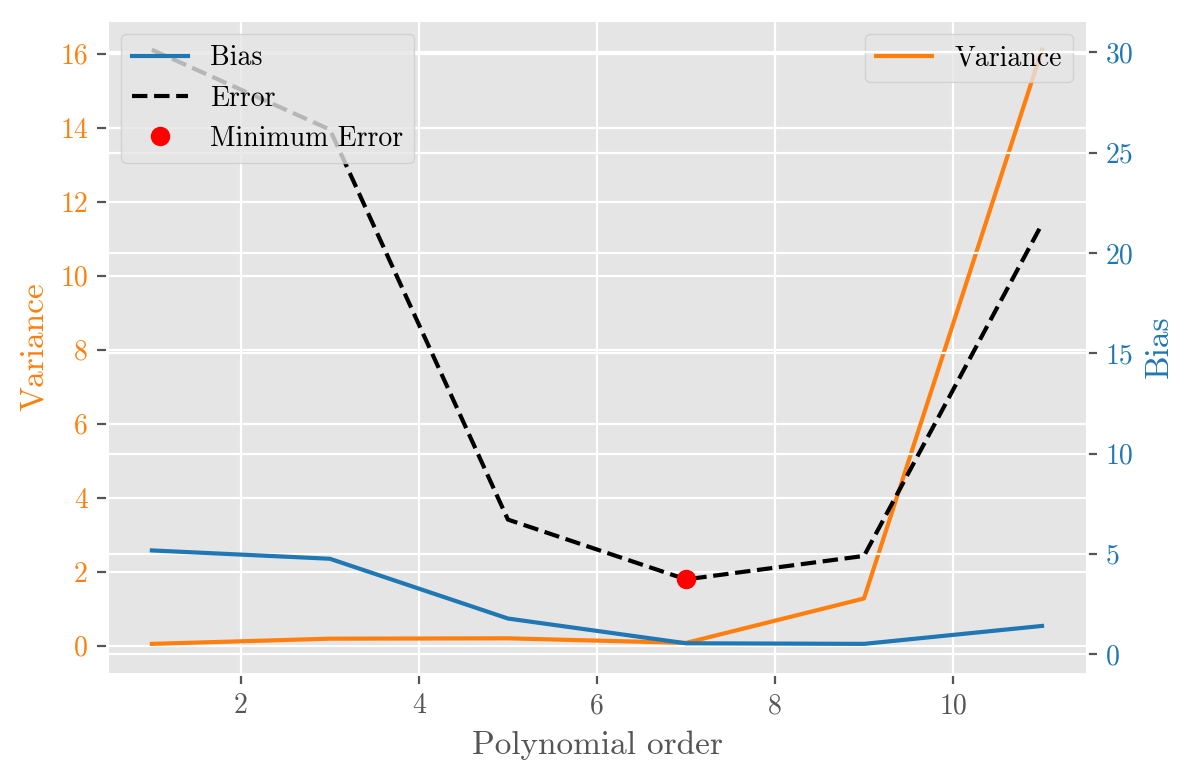

In [176]:
fig, ax1 = plt.subplots(dpi=200)

# график дисперсий
color = 'tab:orange'
ax1.set_xlabel('Polynomial order')  # степень полинома
ax1.set_ylabel('Variance', color=color)  # дисперсия 
ax1.plot(p_order, vv, color=color, label = 'Variance')
ax1.tick_params(axis='y', labelcolor=color)

# график смещений
ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('Bias', color=color)  # смещение
ax2.plot(p_order, bb, color=color,  label = 'Bias')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

# график ошибок
error = np.square(bb) + vv + sigma*len(t)
min_ind = np.argmin(error)  # находим минимальную ошибку

plt.plot(p_order, error, 'k--', label = 'Error')
plt.plot(p_order[min_ind], error[min_ind], 'ro', label= 'Minimum Error')

leg = ax2.legend(loc='upper left')
leg = ax1.legend(loc='upper right')
plt.show()

# Регуляризация (L1 и L2)

*Регуляризация ограничивает величину весовых значений модели*, добавляя штраф для весов к функции ошибки модели. В **L1-регуляризации** *используется сумма абсолютных значений весовых значений*, а в **L2-регуляризации** — *сумма квадратов весовых значений*.

In [203]:
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score

from statistics import mean

In [204]:
df = pd.read_csv('kc_house_data.csv')
 
dropColumns = ['id', 'date', 'zipcode']
df = df.drop(dropColumns, axis = 1)

y = data['price']
X = df.drop('price', axis = 1)
X = np.nan_to_num(X)
 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

### Построение и оценка моделей

##### Linear Regression

In [235]:
linearModel = LinearRegression()
linearModel.fit(X_train, y_train)

scores = cross_val_score(linearModel, X, y, cv=10)
 
reg_res = mean(scores)

##### Ridge (L2) Regression

**Ridge регрессия** или **L2-регуляризация** - метод наложения штрафа в виде квадратов коэффициентов.

In [216]:
cross_val_scores_ridge = []

alpha = []

# alpha : float
# По умолчанию 1.0. Когда альфа равна 0, алгоритм эквивалентен обычному методу наименьших квадратов
# и может быть реализован с помощью линейной регрессии.

for _alpha in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]:
    ridgeModel = Ridge(alpha=_alpha)
    ridgeModel.fit(X_train, y_train)
    
    scores = cross_val_score(ridgeModel, X, y, cv=10)
    
    avg_cross_val_score = mean(scores)
    cross_val_scores_ridge.append(avg_cross_val_score)
    alpha.append(_alpha)

for idx in range(0, len(alpha)):
    print(str(alpha[idx]) + ' : ' + str(cross_val_scores_ridge[idx]))
    
ridge_res = mean(cross_val_scores_ridge)

0.25 : 0.6909021135727202
0.5 : 0.6909038805114043
0.75 : 0.6909054500480246
1.0 : 0.6909068242413389
1.25 : 0.6909080051248868
1.5 : 0.6909089946668628
1.75 : 0.6909097948253893
2.0 : 0.6909104075393401


##### Lasso (L1) Regression

**Lasso регрессия** или **L1-регуляризация** - наложение штрафа в виде абсолютной суммы коэффициентов.

In [224]:
cross_val_scores_lasso = []

alpha = []

for _alpha in [0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0]:
    lassoModel = Lasso(alpha=_alpha)
    lassoModel.fit(X_train, y_train)
    
    scores = cross_val_score(lassoModel, X, y, cv=10)
    avg_cross_val_score = mean(scores)
    
    cross_val_scores_lasso.append(avg_cross_val_score)
    alpha.append(_alpha)

for idx in range(0, len(alpha)):
    print(str(alpha[idx]) + ' : ' + str(cross_val_scores_lasso[idx]))
    
lasso_res = mean(cross_val_scores_lasso)

0.25 : 0.6908464080320115
0.5 : 0.6908464625773882
0.75 : 0.6908465168533711
1.0 : 0.6908465708599609
1.25 : 0.6908466245971574
1.5 : 0.6908466780649593
1.75 : 0.6908467312633597
2.0 : 0.6908467841923673


### Сравнение результатов

In [232]:
results = {}
results['Linear Regression'] = reg_res
results['Ridge Regression'] = ridge_res
results['Lasso Regression'] = lasso_res

for key, val in results.items():
    print(str(key) + ' : '+str(val))

Linear Regression : 0.690900147416467
Ridge Regression : 0.6909069338162459
Lasso Regression : 0.6908465970550719


### Выводы

- **Lasso (L1)** регрессию хорошо использовать, когда какие-то независимые переменные не оказывают значительного влияния на $y$ или же сильно коррелированы между собой. В такой ситуации **Lasso** *может привести к повышению качества модели*. 

- Одновременно с этим, такое свойство **Lasso** *может и навредить*, ведь из-за него *некоторые важные признаки могут выпасть из расчета, что приведет к искажению модели*. Например, если число измерений $p$ меньше числа предикторов $x$, то **Lasso** выберет лишь $p$ предикторов. А если все из исходных предикторов были важны, то какие-то данные в нашей модели просто не будут учтены.

- У **Ridge (L2)** регрессии таких проблем не возникает, т.к. она не приводит к понижению числа переменных, а только лишь к уменьшению сложности модели.

- Необходимо производить предварительный анализ начальных данных: проверять корреляции, оценивать значимость признаков, смотреть на структуру и разброс данных и так далее.

# Сингулярное разложение (SVD)

**Сингулярное разложение** *(Singular Value Decomposition, SVD)* — декомпозиция вещественной матрицы с целью ее *приведения к каноническому виду*. Сингулярное разложение является удобным методом при работе с матрицами. Оно *показывает геометрическую структуру матрицы и позволяет наглядно представить имеющиеся данные*. Сингулярное разложение **используется при решении самых разных задач — от приближения методом наименьших квадратов и решения систем уравнений до сжатия изображений**. При этом используются разные свойства сингулярного разложения, например, *способность показывать ранг матрицы, приближать матрицы данного ранга*. SVD *позволяет вычислять обратные и псевдообратные матрицы большого размера*, что делает его полезным инструментом при решении задач регрессионного анализа.

Данное разложение позволяет представить матрицу $A$ размером $(m,n)$ в виде произведения $A=U \Sigma V^*$, в котором матрица $U$ состоит из левых сингулярных векторов, а матрица $V$ состоит из правых сингулярных векторов. 

- Обе матрицы $U$ и $V$ - это ортогональные (унитарные для комплексных $A$) матрицы. 
- $V^*$ - транспонированная (сопряженно-транспонированная матрица для комплексных $A$). 
- Матрица $\Sigma$ - это диагональная матрица размером $(m,n)$, которая содержит сингулярные числа исходной матрицы $A$.

In [261]:
from scipy.linalg import svd

In [262]:
A = array([[3., 1, 1], [-1, 3, 1]])

print('----- A -----')
print(A)
print('-------------\n')

# SVD
U, sigma, V_t = svd(A)

# левые сингулярные векторы
print('----- U -----')
print(U)
print('-------------\n')

# сингулярные числа
print('----- Sigma -----')
print(sigma)
print('-------------\n')

# правые сингулярные векторы
print('----- V* -----')
print(V_t)
print('---------------\n')

----- A -----
[[ 3.  1.  1.]
 [-1.  3.  1.]]
-------------

----- U -----
[[-0.70710678 -0.70710678]
 [-0.70710678  0.70710678]]
-------------

----- Sigma -----
[3.46410162 3.16227766]
-------------

----- V* -----
[[-4.08248290e-01 -8.16496581e-01 -4.08248290e-01]
 [-8.94427191e-01  4.47213595e-01  5.26260748e-16]
 [-1.82574186e-01 -3.65148372e-01  9.12870929e-01]]
---------------



In [263]:
sigma_d = array([[3.46410162, 0, 0], [0, 3.16227766, 0]])

print('----- Sigma diag -----')
print(sigma_d)
print('------------------')

----- Sigma diag -----
[[3.46410162 0.         0.        ]
 [0.         3.16227766 0.        ]]
------------------


In [264]:
# проверим, что из полученных матриц можно получить исходную
B = U.dot(S_diag.dot(V_T))
print('----- Восстановленная матрица -----')
print(B)
print('--------------------------------')

assert A.all() == B.all()
print('Матрицы A и B равны')

----- Восстановленная матрица -----
[[ 3.  1.  1.]
 [-1.  3.  1.]]
--------------------------------
Матрицы A и B равны


# Робастные (надежные) методы

Специфической проблемой с распределением вероятностей переменных при использовании линейной регрессии являются **выбросы**. Это наблюдения, которые находятся далеко за пределами ожидаемого распределения.

Набор данных может иметь выбросы либо по входным переменным, либо по целевой переменной, и обе могут вызвать проблемы для алгоритма линейной регрессии.

Выбросы в наборе данных могут исказить сводную статистику, рассчитанную для переменной, например, среднее значение и стандартное отклонение, что, в свою очередь, может исказить модель в сторону значений выбросов, вдали от центральной массы наблюдений. Это приводит к тому, что модели пытаются сбалансировать хорошие результаты на выбросах и нормальных данных и хуже на обоих в целом.

Вместо этого решение состоит в том, чтобы использовать модифицированные версии линейной регрессии, которые специально учитывают ожидаемые выбросы в наборе данных. Эти методы называются **надежными алгоритмами регрессии** (robust regression algorithms).

In [240]:
from random import random, randint, seed

from numpy import arange

from sklearn.datasets import make_regression

from sklearn.linear_model import LinearRegression  # не робастный метод
from sklearn.linear_model import HuberRegressor, RANSACRegressor, TheilSenRegressor  # робастные методы

from matplotlib import pyplot

In [241]:
def get_dataset():
    """Подготовка датасета"""
    X, y = make_regression(n_samples=100, n_features=1, tail_strength=0.9, effective_rank=1, n_informative=1, noise=3, bias=50, random_state=1)
    seed(1)  # задает значение генератора случайных чисел, равное x, и возвращает предыдущее значение
    
    for i in range(10):
        factor = randint(2, 4)
        if random() > 0.5:
            X[i] += factor * X.std()
        else:
            X[i] -= factor * X.std()
    return X, y
 
def get_models():
    """Словарь моделей"""
    models = list()
    
    models.append(LinearRegression())
    models.append(HuberRegressor())
    models.append(RANSACRegressor())
    models.append(TheilSenRegressor())
    
    return models
 
def plot_best_fit(X, y, xaxis, model):
    """Отрисовка данных и результатов моделей"""
    model.fit(X, y)  # обучаем модель
    yaxis = model.predict(xaxis.reshape((len(xaxis), 1)))  # предсказываем
    pyplot.plot(xaxis, yaxis, label=type(model).__name__)  # рисуем предсказание

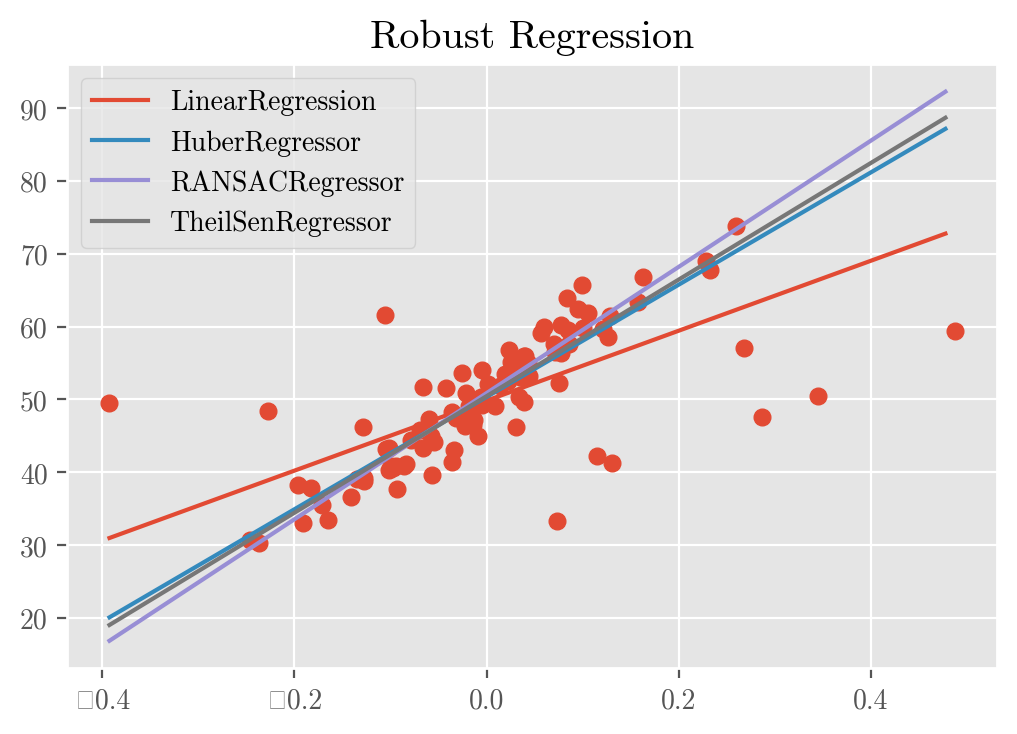

In [265]:
X, y = get_dataset()

xaxis = arange(X.min(), X.max(), 0.01)  # сетка графика

fig, ax1 = plt.subplots(dpi=200)
for model in get_models():
    plot_best_fit(X, y, xaxis, model)  # отрисовываем предсказания каждой модели
    
pyplot.scatter(X, y)
pyplot.title('Robust Regression')
pyplot.legend()
pyplot.show()